In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

# Check for GPU
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

/Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/edwardwang/micromamba/envs/rps_detection/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/edwardwang/micromamba/envs/rps_detection/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functio

Using device: mps


In [2]:
# Define transformations - keep consistent between train and test
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
data_dir = "./dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class mapping and dataset sizes
class_names = list(train_dataset.class_to_idx.keys())
print("Class mapping:", train_dataset.class_to_idx)
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Classes: {class_names}")

Class mapping: {'paper': 0, 'rock': 1, 'scissor': 2, 'unknown': 3}
Training images: 1796
Validation images: 200
Classes: ['paper', 'rock', 'scissor', 'unknown']


In [3]:
# Define CNN Model
class RockPaperScissorsCNN(nn.Module):
    def __init__(self):
        super(RockPaperScissorsCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, len(class_names))  # Dynamic based on classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = RockPaperScissorsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training function with accuracy tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, labels)
        
        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy = running_accuracy / len(train_loader) * 100
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, labels)
                
                # For confusion matrix
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader) * 100
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%")
    
    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Create confusion matrix for validation set
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Validation Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Evaluate on a few sample images from validation set
    visualize_predictions(model, val_loader, class_names, device, num_images=5)
    
    return model

# Function to visualize some predictions
def visualize_predictions(model, data_loader, class_names, device, num_images=5):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    # Get predictions
    with torch.no_grad():
        images = images[:num_images].to(device)
        labels = labels[:num_images].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Plot images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    
    for i, ax in enumerate(axes):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        # Denormalize
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", 
                    color=("green" if preds[i] == labels[i] else "red"))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
  Train Loss: 0.0378, Train Accuracy: 98.85%
  Val Loss: 0.0478, Val Accuracy: 98.66%
Epoch 2/10
  Train Loss: 0.0040, Train Accuracy: 99.89%
  Val Loss: 0.0255, Val Accuracy: 98.66%
Epoch 3/10
  Train Loss: 0.0007, Train Accuracy: 100.00%
  Val Loss: 0.0080, Val Accuracy: 99.55%
Epoch 4/10
  Train Loss: 0.0003, Train Accuracy: 100.00%
  Val Loss: 0.0118, Val Accuracy: 99.55%
Epoch 5/10
  Train Loss: 0.0001, Train Accuracy: 100.00%
  Val Loss: 0.0077, Val Accuracy: 99.55%
Epoch 6/10
  Train Loss: 0.0001, Train Accuracy: 100.00%
  Val Loss: 0.0095, Val Accuracy: 99.55%
Epoch 7/10
  Train Loss: 0.0001, Train Accuracy: 100.00%
  Val Loss: 0.0068, Val Accuracy: 99.55%
Epoch 8/10
  Train Loss: 0.0000, Train Accuracy: 100.00%
  Val Loss: 0.0072, Val Accuracy: 99.55%
Epoch 9/10
  Train Loss: 0.0000, Train Accuracy: 100.00%
  Val Loss: 0.0070, Val Accuracy: 99.55%
Epoch 10/10
  Train Loss: 0.0000, Train Accuracy: 100.00%
  Val Loss: 0.0072, Val Accuracy: 99.55%


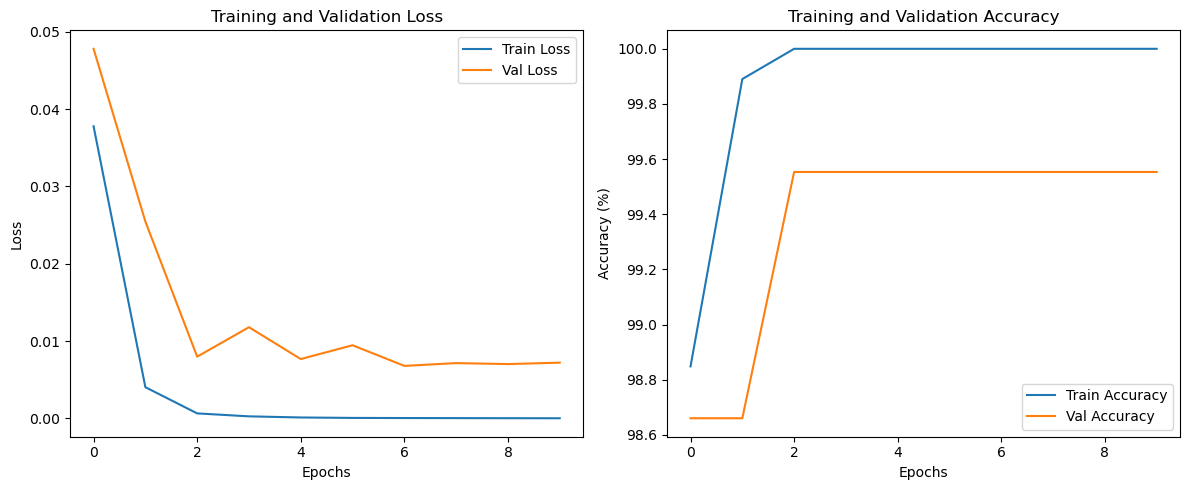

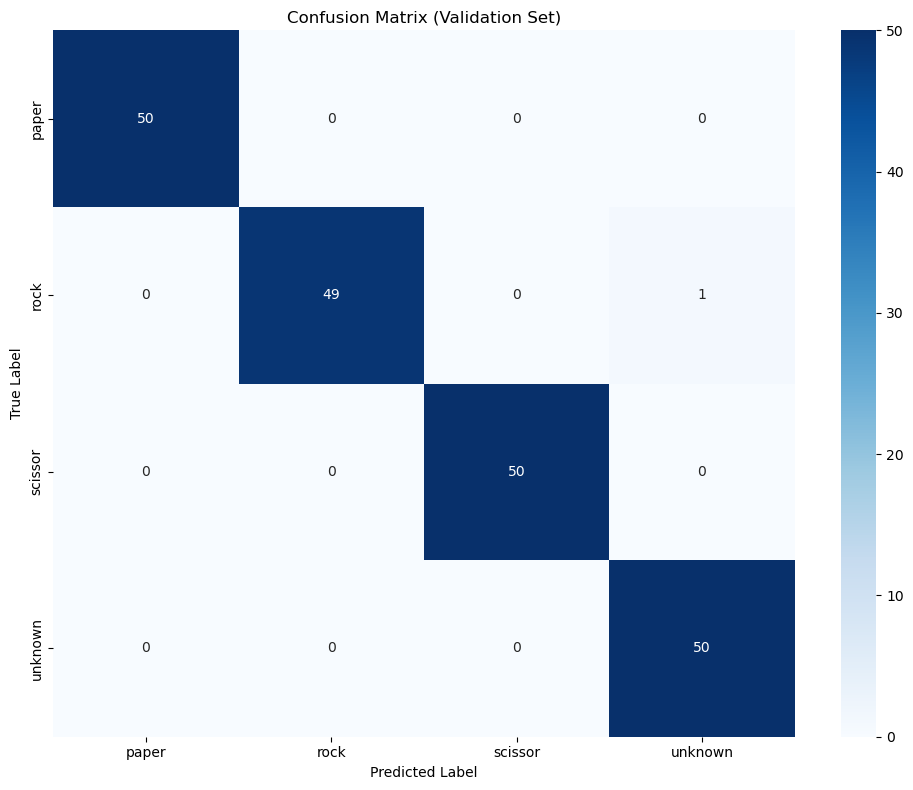

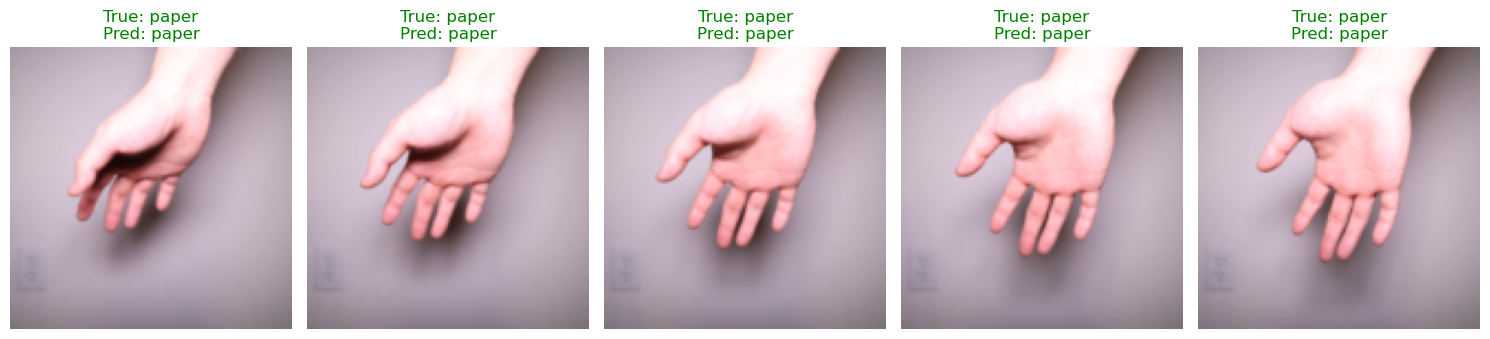

In [5]:
# Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [6]:
# Final evaluation on validation set
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    
    print(f"Final Validation Results:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  {correct}/{total} samples correctly classified")
    
    return avg_loss, accuracy

print("\nEvaluating model on validation set...")
evaluate_model(model, val_loader, criterion, device)

# Save the trained model with additional information
model_info = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': train_dataset.class_to_idx,
    'class_names': class_names
}
torch.save(model_info, "rps_model_improved.pth")
print("Model saved as rps_model_improved.pth with class mapping information")


Evaluating model on validation set...
Final Validation Results:
  Loss: 0.0072
  Accuracy: 99.50%
  199/200 samples correctly classified
Model saved as rps_model_improved.pth with class mapping information
